In [12]:
import os
import sys

import multiprocess as mp

import mirnylib.plotting
import cooler
import cooltools
from cooltools import insulation, snipping
import bioframe
from sklearn.mixture import GaussianMixture
from mirnylib.numutils import zoomArray
from functools import partial

import DNA_info
import matrix_manager as mm
import cooltools_pileups
import feature_merging
from feature_merging import bedpeslice
%matplotlib notebook

In [4]:
def rao_insulations():
    rao_path = './GSE63525_GM12878_primary+replicate_Arrowhead_domainlist_hg38.txt'
    rao_ins = pd.read_csv(rao_path, sep='\t')
    rao_starts = rao_ins[['chrom1','start1']].rename(columns={'chrom1':'chrom', 'start1':'pos'})
    rao_ends = rao_ins[['chrom1','end1']].rename(columns={'chrom1':'chrom', 'end1':'pos'})
    rao_ins = pd.concat([rao_starts, rao_ends]).sort_values(['chrom','pos'])

    ind = (rao_ins.iloc[1:]['pos'].values - rao_ins.iloc[0:-1]['pos'].values < 20000)
    ind = ind & (rao_ins.iloc[1:]['chrom'].values == rao_ins.iloc[0:-1]['chrom'].values)
    ind  = np.append(ind, True)
    rao_ins = rao_ins[~ind].reset_index(drop=True)
    
    return rao_ins

def link_adjacent_sites(df):
    assert np.all([x in df.columns for x in ['chrom', 'start', 'end']])
    df = df.dropna()
    
    l_df = df.iloc[0:-1].copy().reset_index(drop=True)
    l_df.columns = [x+'1' for x in l_df.columns]
    r_df = df.iloc[1:].copy().reset_index(drop=True)
    r_df.columns = [x+'2' for x in r_df.columns]

    df2 = pd.concat([l_df, r_df], axis=1)
    df2 = df2[df2.chrom1==df2.chrom2]
    
    return df2

def rescale_snips(arguments):
    snip, size = arguments
#     start = tad_list.loc[index, 'start']
#     end = tad_list.loc[index, 'end']
#     size = (end-start)//1000
    s = snip[100-size:100+size,100-size:100+size]
    s[~np.isfinite(s)] = 0
    s = zoomArray(s, (100,100))
    
    return s

def tad_metric_rao(pileup):
    assert pileup.shape[0] == 100
    assert pileup.shape[1] == 100
    
    mid = pileup[25:75,25:75]
    mask = np.arange(len(mid))
    mask = (np.abs(mask[None,:]- mask[:,None]) < 12) | (np.abs(mask[None,:]- mask[:,None]) > 40)
    mid[mask] = 0
    mid = np.triu(mid)
    mid = np.nanmean(mid[mid!=0].flatten())
    
    top = pileup[40:75, 80:].flatten()
    bot = pileup[0:20,25:60].flatten()
    out = np.nanmean(top+bot)/2
    
    return mid/out

def parallelize(tad_list, good_inds, name_snips):
    name, snips = name_snips
    print(name)
    
    snips = snips.load()
    if np.all(np.isnan(snips)):
        print(np.nan)
        return np.nan
    
    snips = snips[:,:, good_inds]
    arguments = [(snips[:,:,i], tad_list.loc[i, 'size']) for i in range(len(tad_list))]        
    new_snips = list(map(rescale_snips, arguments))
    new_snips = np.dstack(new_snips)

    pileup = np.nanmean(new_snips, axis=2)
    score = tad_metric_rao(pileup)
    
    print(score)
    return score

# Generating pileups

In [ ]:
db = mm.Dataset()
table = db.get_tables()
insulations = mm.filter_data(table, filter_dict={'seq':'deep'})
insulations = mm.get_insulation(insulations, res=10000)
table = mm.get_coolers(table, res=10000)
arms = DNA_info.get_chromosome_arms('hg38')
basepath = '/net/levsha/share/sameer/U54/hic_matrix/pileups/boundaries/'

for _, row in insulations.iterrows():
    print(row['lib_name'])
    lib_name = row['lib_name']
    insul = row['insulation_10000']
    insul = insul.rename(columns={'log2_insulation_score_100000':'insul_score',
                                  'boundary_strength_100000':'strength'})
    insul = insul[['chrom','start','end','insul_score','strength','category']].dropna()
    
    for cat in ['all', 'strong','weak']:
        ins = insul.copy()
        if cat is not 'all':
            ins = ins[ins.category == cat]
        insul_tads = link_adjacent_sites(ins)
        insul_tads['pos'] = (insul_tads['start1'] + insul_tads['start2'])//2
        
        binned_list = snipping.make_bin_aligned_windows(10000, insul_tads['chrom1'].values, 
                                               insul_tads['pos'].values, flank_bp=1000000)
        features = snipping.assign_regions(binned_list, arms)
        assert np.all(features['region'].apply(lambda x: isinstance(x, str)))
        
        savepath = f'{basepath}{lib_name}/{cat}/10000/'
        os.makedirs(savepath, exist_ok=True)
        df = insul_tads[['chrom1','start1','start2','pos','strength1','strength2']]
        df = df.rename(columns={'chrom1':'chrom','start1':'start','start2':'end',
                                'strength1':'start_strength', 'strength2':'end_strength'})
        assert len(df) == len(features)
        df.to_csv(f'{savepath}/tadlist.txt', sep='\t', header=True, index=False)

        for _, row2 in table.iterrows():
            name = row2['lib_name']
            print(name)

            cool = row2[f'cooler_{10000}']

            snipper = cooltools_pileups.LocalObsExpSnipper(cool, cooler_opts={'balance':True})
            with mp.Pool(20) as p:
                pileup = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)
 
            np.save(f'{savepath}/{name}.npy', pileup)
            print(f'Saved to: {savepath}/{name}.npy')
        
    

# Visualizing and Scoring

In [ ]:
list_names = db.get_tables()
list_names = mm.filter_data(list_names, filter_dict={'seq':'deep'})
list_names = ['rao2014'] + list(list_names['lib_name'].values) 
list_names

In [ ]:
# db = mm.Dataset()
# tad_scores_df = db.get_tables()
# # tad_scores_df = mm.filter_data(tad_scores_df)
# tad_scores_df = tad_scores_df[['lib_name']]
# tad_scores_df.to_csv('./tad_scores_strong.txt', sep='\t', header=True, index=False)

In [ ]:
base_path = '/net/levsha/share/sameer/U54/hic_matrix/pileups/tads/'
db = mm.Dataset()
list_names = db.get_tables()
list_names = mm.filter_data(list_names, filter_dict={'seq':'deep'})
list_names = ['rao2014'] + list(list_names['lib_name'].values) 

tad_scores_df = pd.read_csv('./tad_scores_strong.txt', sep='\t')
for name in list_names[-2:-1]:
    print(f'\n***** {name} ****\n')
    
    if name == 'rao2014':
        list_file = 'GSE63525_GM12878_primary+replicate_Arrowhead_domainlist_hg38.txt'
        subfolder = name
    else:
        list_file = 'tadlist_10000.txt'
        subfolder = f'{name}/strong'
        
    print(subfolder)
    
    tad_list = pd.read_csv(f'{base_path}{subfolder}/{list_file}', sep='\t')
    if name == 'rao2014':
        tad_list = tad_list.rename(columns={'chrom1':'chrom', 'start1':'start', 'end1':'end'})
        tad_list = tad_list[['chrom','start','end']]
    tad_list['size'] = tad_list['end'] - tad_list['start']
   
    print(tad_list.shape)
    good_inds = tad_list.loc[(tad_list['size'] >= 10**5) & (tad_list['size'] < 10**6)].index.values
    tad_list = tad_list.loc[good_inds].reset_index(drop=True)
    print(tad_list.shape)
    
    table = db.get_tables()
    table = mm.get_tads(table, subfolder, res=10000)
#     table = mm.filter_data(table, filter_dict={'celltype':['END','ESC','HFF']})
    
    tad_scores = []
    for i, row in table.iterrows():
        print(row['lib_name'])
        
        snips = row['tads_10000'].load()
        
        if np.all(np.isnan(snips)):
            tad_scores.append(np.nan)
            print(np.nan)
            continue
        snips = snips[:,:, good_inds]
        
        arguments = [(snips[:,:,i], tad_list.loc[i, 'size']//10000) for i in range(len(tad_list))]
        with mp.Pool(20) as p:
            new_snips = list(p.map(rescale_snips, arguments))
        new_snips = np.dstack(new_snips)

        pileup = np.nanmean(new_snips, axis=2)
        score = tad_metric_rao(pileup)
        print(score)
        tad_scores.append(score)
        
        if np.random.random() < (3/70):
            plt.figure()
            plt.imshow(pileup, cmap='coolwarm')
    
    tad_scores_df[f'{name}'] = tad_scores
    tad_scores_df.to_csv('./tad_scores_strong.txt', sep='\t', header=True, index=False)

In [ ]:
tad_df = pd.read_csv('./tad_scores_strong.txt', sep='\t')
tad2 = pd.read_csv('./tad_scores.txt', sep='\t')
tad_df = tad_df.merge(tad2[['lib_name','rao2014']], on='lib_name', how='outer')

db = mm.Dataset()
df = db.get_tables(['scaling_metrics'])
df = mm.filter_data(df, filter_dict={'cycle':['NS']})
df = df.merge(tad_df, on='lib_name', how='outer').dropna()
df

In [ ]:
list_names = [col for col in tad_df.columns if col != 'lib_name']
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,6), sharex=True, sharey=False, constrained_layout=True)
ax = ax.ravel()

cat = 'enzyme'
if cat == 'celltype':
    colors = {'END':'g', 'ESC':'r', 'HFF':'b', 'HelaS3':'y'}
elif cat == 'xlink':
    colors = {'DSG':'r', 'EGS':'b', 'FA':'g'}
else:
    colors = {'MNase':'g', 'DpnII':'r', 'DdeI':'b', 'HindIII':'y'}
    
for i, name in enumerate(list_names):

    ax[i].set_title(name)
    for ct, group in df.groupby(cat):
        x = group['avg_slope_100kb'].values
        y = group[name].values
        ax[i].scatter(x, y, label=ct, color=colors[ct])
ax[2].legend(bbox_to_anchor=[1, 0.5], loc='center left')

fig.savefig(f'/home/sameer/Dropbox (MIT)/Research/U54_matrix/insulation/tads/strong/tad_score_v_slope_strong_enzyme.pdf', format='pdf')

# Merging list of boundaries and making TADs from them

In [65]:
arms = DNA_info.get_chromosome_arms('hg38')
res = 10000
db = mm.Dataset()
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep'})
table = mm.get_insulation(table, res=res)
table = mm.get_coolers(table, res=res)
table

,lib_name,seq,celltype,xlink,enzyme,cycle,insulation_10000_win10,cooler_10000
0,U54-END4DN-FA-DSG-MNase-R1-R2_hg38,deep,END,DSG,MNase,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-END4DN-FA-DSG-MNase-R1-R2_hg38.hg..."
1,U54-END-FA-DpnII-R1-R2_hg38,deep,END,FA,DpnII,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-END-FA-DpnII-R1-R2_hg38.hg38.mapq..."
2,U54-ESC4DN-DSG-DpnII-R1-R2_hg38,deep,ESC,DSG,DpnII,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-ESC4DN-DSG-DpnII-R1-R2_hg38.hg38...."
3,U54-H1ESC4DN-FA-DSG-MNase-R1-R2_hg38,deep,ESC,DSG,MNase,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-H1ESC4DN-FA-DSG-MNase-R1-R2_hg38...."
4,U54-ESC4DN-FA-DpnII-R1-R2_hg38,deep,ESC,FA,DpnII,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-ESC4DN-FA-DpnII-R1-R2_hg38.hg38.m..."
5,U54-HFFc6-DSG-DdeI-R1-R2_hg38,deep,HFF,DSG,DdeI,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-HFFc6-DSG-DdeI-R1-R2_hg38.hg38.ma..."
6,U54-HFFc6-DSG-DpnII-R1-R2_hg38,deep,HFF,DSG,DpnII,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-HFFc6-DSG-DpnII-R1-R2_hg38.hg38.m..."
7,U54-HFFc6-FA-DSG-MNase-R1-R3_hg38,deep,HFF,DSG,MNase,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-HFFc6-FA-DSG-MNase-R1-R3_hg38.hg3..."
8,U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-R3_hg38,deep,HFF,DSG,double,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-HFFc6-DSG-DdeI-DpnII-20190711-R1-..."
9,U54-HFFc6-FA-DpnII-R1-R2_hg38,deep,HFF,FA,DpnII,NS,chrom start end is_bad_bin ...,"<Cooler ""U54-HFFc6-FA-DpnII-R1-R2_hg38.hg38.ma..."


/home/sameer/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


<IPython.core.display.Javascript object>


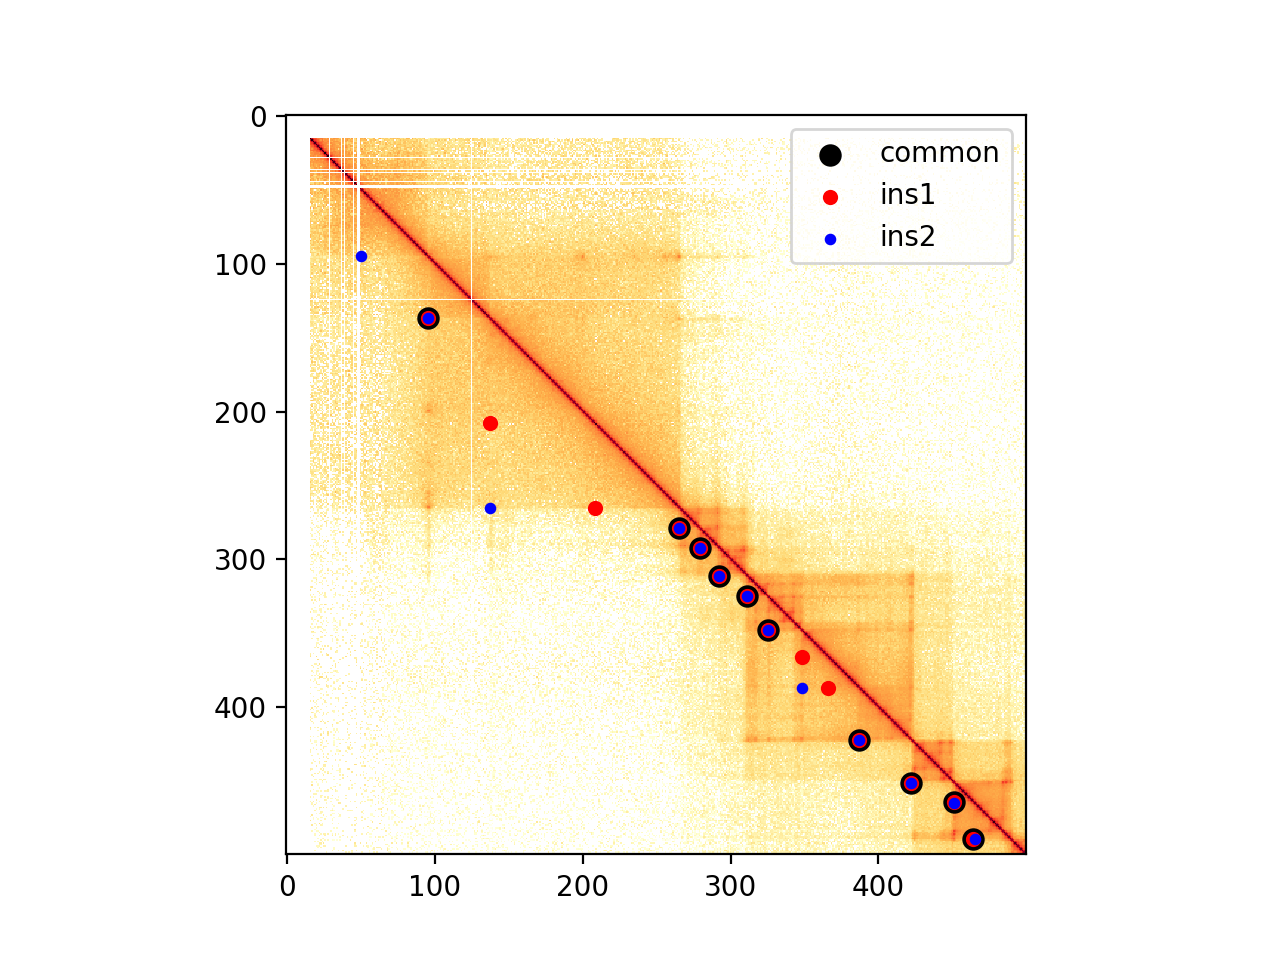

In [66]:
ins1 = table.loc[8, 'insulation_10000_win10']
ins1 = ins1.loc[ins1['category'].apply(lambda x: x == 'strong')].reset_index(drop=True)
ins1['pos'] = (ins1['start'] + ins1['end'])//2
ins1 = ins1[['chrom','start','end','pos']]#.rename(columns= lambda x: x+'1')
ins1 = link_adjacent_sites(ins1)
# ins1[['chrom2','start2','end2','pos2']] = ins1[['chrom1','start1','end1','pos1']]

ins2 = table.loc[7, 'insulation_10000_win10']
ins2 = ins2.loc[ins2['category'].apply(lambda x: x == 'strong')].reset_index(drop=True)
ins2['pos'] = (ins2['start'] + ins2['end'])//2
ins2 = ins2[['chrom','start','end','pos']]#.rename(columns= lambda x: x+'1')
ins2 = link_adjacent_sites(ins2)
# ins2[['chrom2','start2','end2','pos2']] = ins2[['chrom1','start1','end1','pos1']]

common = feature_merging.intersection(ins1, ins2, return_unique=False)
# union = feature_merging.union(ins1, ins2)

chrom = 'chr5'
start = 50000000
end = 55000000

cool = table.loc[7, 'cooler_10000']
mat = cool.matrix(balance=True).fetch((chrom, start, end))
mat = np.log10(mat)

sub_df1 = bedpeslice(ins1, chrom, start, end)
sub_df2 = bedpeslice(ins2, chrom, start, end)
sub_df3 = bedpeslice(common, chrom, start, end)

fig, ax = plt.subplots()
ax.imshow(mat, cmap='fall')

x = sub_df3['pos1'].values
x = (x - start)//res
y = sub_df3['pos2'].values
y = (y - start)//res
ax.scatter(x, y, alpha=1, color='k', s=50, label='common')

x = sub_df1['pos1'].values
x = (x - start)//res
y = sub_df1['pos2'].values
y = (y - start)//res
ax.scatter(x, y, alpha=1, color='r', s=20, label='ins1')

x = sub_df2['pos1'].values
x = (x - start)//res
y = sub_df2['pos2'].values
y = (y - start)//res
ax.scatter(x, y, alpha=1, color='b', s=10, label='ins2')

ax.legend()

In [27]:
??feature_merging.intersection

<IPython.core.display.Javascript object>


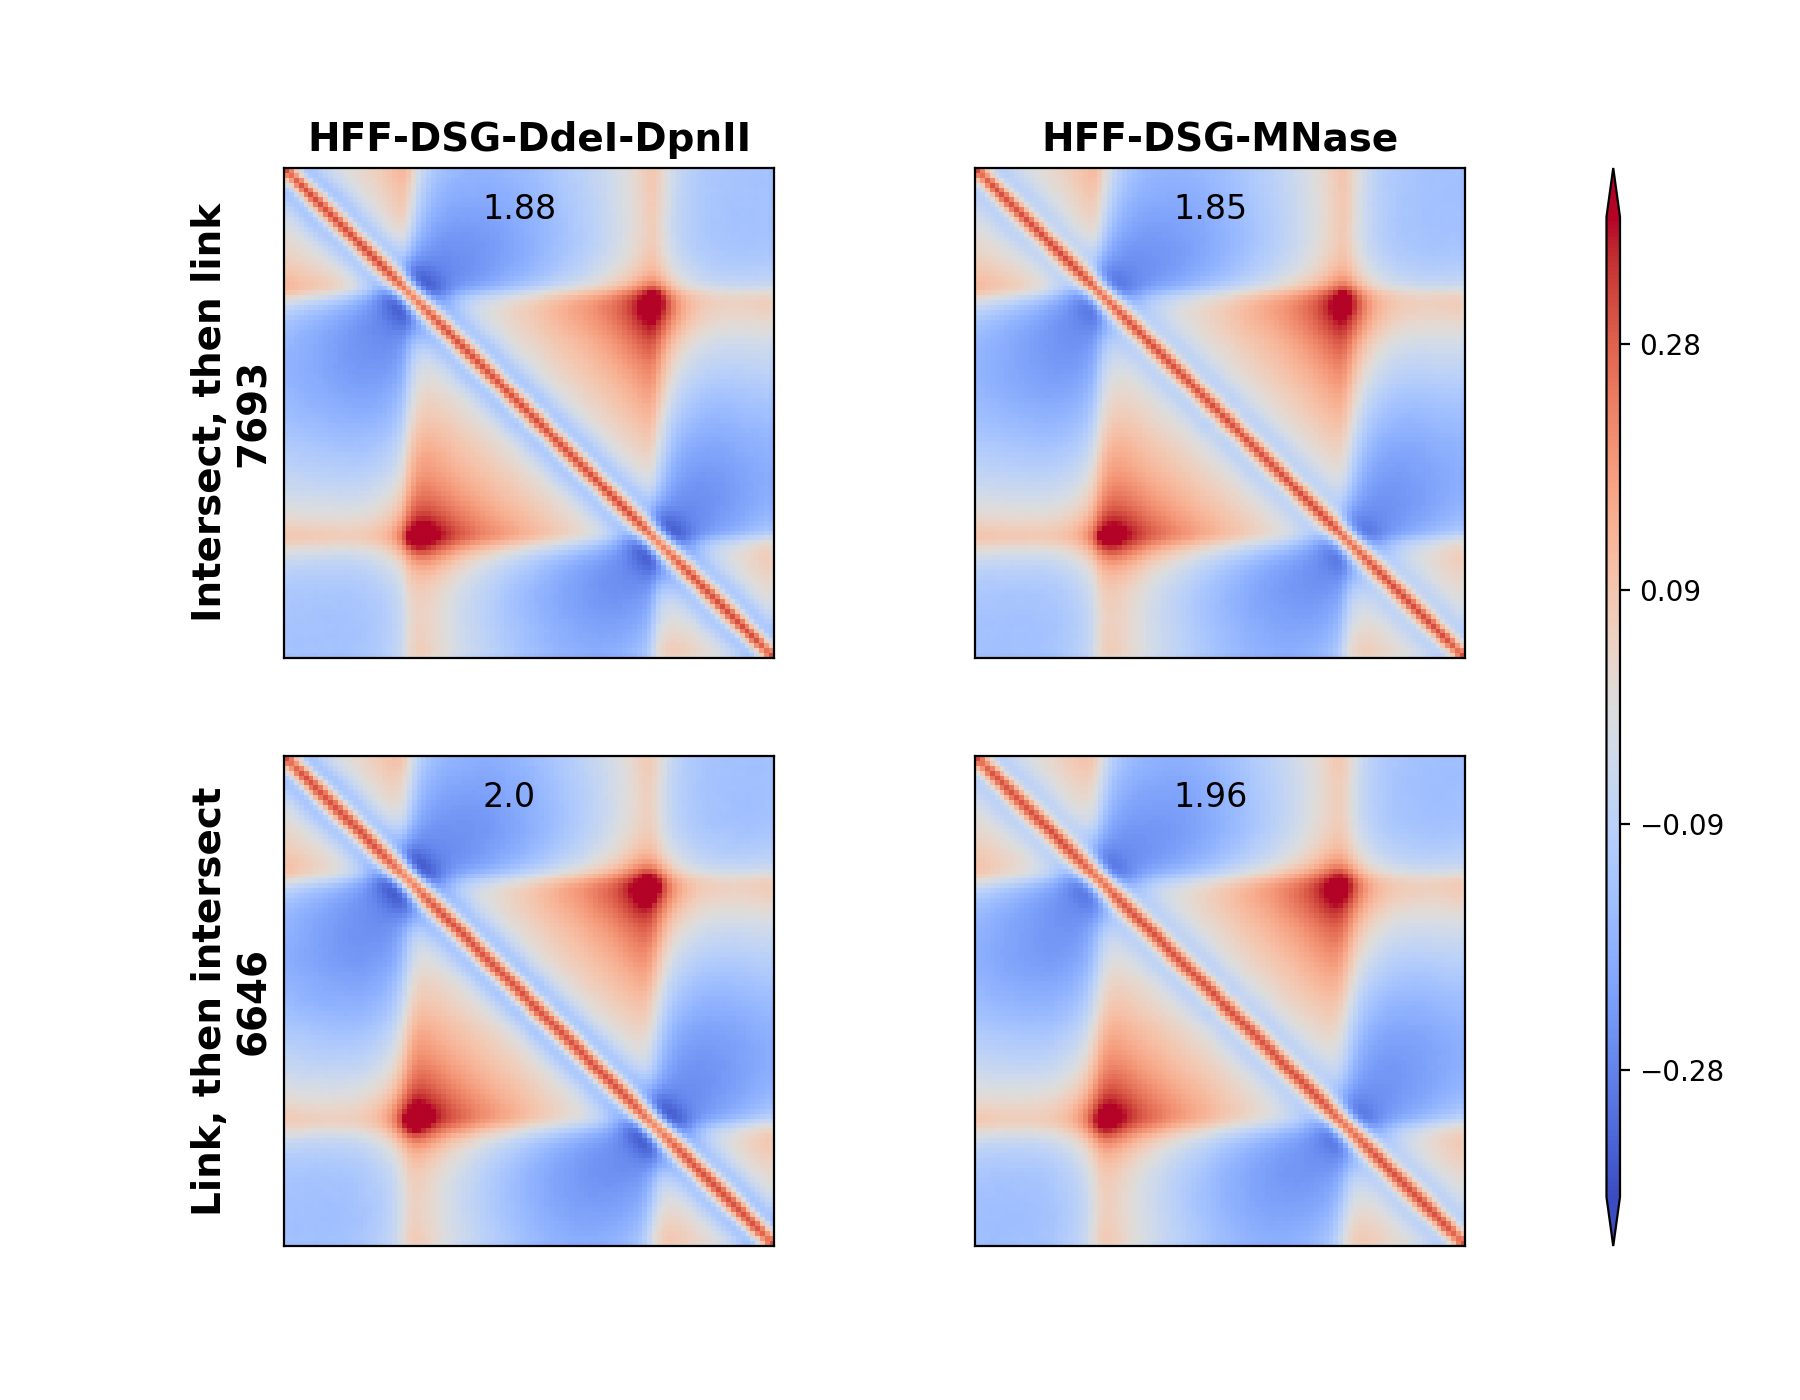

('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr19', 25844927, 58617616) ('chr19', 25844927, 58617616)
('chr2', 0, 93139351) ('chr2', 0, 93139351)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr19', 0, 2584492

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr2', 0, 93139351) ('chr2', 0, 93139351)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr19', 25844927, 58617616) ('chr19', 25844927, 58617616)
('chr18'

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)
('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr19', 25844927, 58617616) ('chr19', 25844927, 58617616)
('chr2', 0, 93139351) ('chr2', 0, 93139351)
('chr19'

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 44454096, 138394717)
('chrX', 0, 60509060) ('chrX', 0, 60509060)
('chrX', 60509060, 156040895) ('chrX', 60509060, 156040895)
('chrY', 0, 10430491) ('chrY', 0, 10430491)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr1', 0, 123479591) ('chr1', 0, 123479591)
('chr1', 123479591, 248956422) ('chr1', 123479591, 248956422)
('chr10', 0, 40640101) ('chr10', 0, 40640101)
('chr10', 40640101, 133797422) ('chr10', 40640101, 133797422)
('chr11', 0, 52751711) ('chr11', 0, 52751711)
('chr12', 0, 35977329) ('chr12', 0, 35977329)
('chr11', 52751711, 135086622) ('chr11', 52751711, 135086622)
('chr12', 35977329, 133275309) ('chr12', 35977329, 133275309)
('chr13', 17025624, 114364328) ('chr13', 17025624, 114364328)
('chr14', 17086761, 107043718) ('chr14', 17086761, 107043718)
('chr15', 18404463, 101991189) ('chr15', 18404463, 101991189)
('chr16', 0, 37288413) ('chr16', 0, 37288413)
('chr17', 0, 24714921) ('chr17', 0, 24714921)
('chr16', 37288413, 90338345) ('chr16', 37288413, 90338345)
('chr19', 25844927, 58617616) ('chr19', 25844927, 58617616)
('chr17', 24714921, 83257441) ('chr17', 24714921, 83257441)
('chr2', 0, 93139351) ('chr2', 0, 93139351)
('chr18', 0, 18161052) ('chr18', 0, 18161052)
('chr18', 18161052, 

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]
/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chr2', 93139351, 242193529) ('chr2', 93139351, 242193529)
('chr20', 0, 28237290) ('chr20', 0, 28237290)
('chr20', 28237290, 64444167) ('chr20', 28237290, 64444167)
('chr21', 11890184, 46709983) ('chr21', 11890184, 46709983)
('chr22', 14004553, 50818468) ('chr22', 14004553, 50818468)
('chr3', 0, 92214016) ('chr3', 0, 92214016)
('chr3', 92214016, 198295559) ('chr3', 92214016, 198295559)
('chr4', 0, 50728006) ('chr4', 0, 50728006)
('chr4', 50728006, 190214555) ('chr4', 50728006, 190214555)
('chr5', 0, 48272853) ('chr5', 0, 48272853)
('chr5', 48272853, 181538259) ('chr5', 48272853, 181538259)
('chr6', 0, 59191911) ('chr6', 0, 59191911)
('chr6', 59191911, 170805979) ('chr6', 59191911, 170805979)
('chr7', 0, 59848836) ('chr7', 0, 59848836)
('chr7', 59848836, 159345973) ('chr7', 59848836, 159345973)
('chr8', 0, 44955504) ('chr8', 0, 44955504)
('chr8', 44955504, 145138636) ('chr8', 44955504, 145138636)
('chr9', 0, 44454096) ('chr9', 0, 44454096)
('chr9', 44454096, 138394717) ('chr9', 4445409

/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


('chrY', 10430491, 57227415) ('chrY', 10430491, 57227415)


/net/levsha/share/sameer/github/mirnylab-experimental/sameer/pileups/cooltools_pileups.py:82: RuntimeWarning: invalid value encountered in true_divide
  coarse_expected = log_scaling[1:]/log_count[1:]


In [96]:
ind1, ind2 = 7, 8
name1 = 'HFF-DSG-DdeI-DpnII'#table.loc[ind1, 'lib_name']
name2 = 'HFF-DSG-MNase'#table.loc[ind2, 'lib_name']
ins1 = table.loc[ind1, 'insulation_10000_win10']
ins1 = ins1.loc[ins1['category'].apply(lambda x: x == 'strong')].reset_index(drop=True)
ins1['pos'] = (ins1['start'] + ins1['end'])//2
ins1 = ins1[['chrom','start','end','pos']]

ins2 = table.loc[ind2, 'insulation_10000_win10']
ins2 = ins2.loc[ins2['category'].apply(lambda x: x == 'strong')].reset_index(drop=True)
ins2['pos'] = (ins2['start'] + ins2['end'])//2
ins2 = ins2[['chrom','start','end','pos']]

cool1 = table.loc[ind1, 'cooler_10000']
cool2 = table.loc[ind2, 'cooler_10000']


fig = plt.figure(figsize=(9, 7))
gs = GridSpec(nrows=2, ncols=3, width_ratios=[90,90,2])
for i in range(2):
    df1 = ins1.copy(deep=True)
    df2 = ins2.copy(deep=True)
    if not i:
        df1 = df1.rename(columns= lambda x: x+'1')
        df2 = df2.rename(columns= lambda x: x+'1')
        df1[['chrom2','start2','end2','pos2']] = df1[['chrom1','start1','end1','pos1']]
        df2[['chrom2','start2','end2','pos2']] = df2[['chrom1','start1','end1','pos1']]
        common = feature_merging.intersection(df1, df2, return_unique=False)
        common = common[['chrom1','start1','end1']].rename(columns=lambda x: x[0:-1])
        common = link_adjacent_sites(common)
        common['pos'] = (common['start1'] + common['start2'])//2
        common['size'] = common['start2'] - common['start1']
    else:
        df1 = link_adjacent_sites(df1)
        df2 = link_adjacent_sites(df2)
        common = feature_merging.intersection(df1, df2, return_unique=False)
        common['pos'] = (common['pos1'] + common['pos2'])//2
        common['size'] = common['pos2'] - common['pos1']
    
    common = common.loc[(common['size'] >= 10**5) & (common['size'] < 10**6)].reset_index(drop=True)
    binned_list = snipping.make_bin_aligned_windows(res, common['chrom1'].values, 
                                           common['pos'].values, flank_bp=1000000)
    features = snipping.assign_regions(binned_list, arms)
    assert np.all(features['region'].apply(lambda x: isinstance(x, str)))


    snipper = cooltools_pileups.LocalObsExpSnipper(cool1, cooler_opts={'balance':True})
    with mp.Pool(20) as p:
        snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

    arguments = [(snips[:,:,i], common.loc[i, 'size']//res) for i in range(len(common))]
    with mp.Pool(20) as p:
        new_snips = list(p.map(rescale_snips, arguments))
    new_snips = np.dstack(new_snips)

    pileup1 = np.nanmean(new_snips, axis=2)
    score1 = np.round(tad_metric_rao(pileup1.copy()), 2)
    pileup1 = np.log10(pileup1)
    
    snipper = cooltools_pileups.LocalObsExpSnipper(cool2, cooler_opts={'balance':True})
    with mp.Pool(20) as p:
        snips = snipping.pileup(features, snipper.select, snipper.snip, map=p.map)

    arguments = [(snips[:,:,i], common.loc[i, 'size']//res) for i in range(len(common))]
    with mp.Pool(20) as p:
        new_snips = list(p.map(rescale_snips, arguments))
    new_snips = np.dstack(new_snips)

    pileup2 = np.nanmean(new_snips, axis=2)
    score2 = np.round(tad_metric_rao(pileup2.copy()), 2)
    pileup2 = np.log10(pileup2)
    
    lim = np.max([np.nanpercentile(np.abs(pileup1), 99.5), np.nanpercentile(np.abs(pileup2), 99.5)])
    
    ax1 = fig.add_subplot(gs[i,0])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(pileup1, cmap='coolwarm', vmin=-lim, vmax=lim)
    ax1.text(40, 10, score1, fontsize=12)
    
    ax2 = fig.add_subplot(gs[i,1])
    ax2.set_xticks([])
    ax2.set_yticks([])
    img = ax2.imshow(pileup2, cmap='coolwarm', vmin=-lim, vmax=lim)
    ax2.text(40, 10, score2, fontsize=12)
    
    if i == 0:
        ax1.set_title(name1, fontsize=14, fontweight='bold')
        ax2.set_title(name2, fontsize=14, fontweight='bold')
        ax1.set_ylabel(f'Intersect, then link\n{len(common)}', fontsize=14, fontweight='bold')
    else:
        ax1.set_ylabel(f'Link, then intersect\n{len(common)}', fontsize=14, fontweight='bold')
        
f = lambda x: np.round(x, 2)
cax = fig.add_subplot(gs[:,2])
cbar = plt.colorbar(img, cax=cax, ticks=[f(-3*lim/4), f(-lim/4), f(lim/4), f(3*lim/4)], extend='both')
fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/tad_methods.png', format='png')

In [ ]:
fig, ax = plt.subplots(ncols=2)
ind = 28#np.random.choice(tads.index.values)
l = tads.loc[ind].copy()
l['pos'] = (l['start1'] + l['end1'])//2
size = l['size']//10000
st = (l['pos'] - l['start1'])//10000
end = (l['end1'] - l['pos'])//10000
p = pu[100-size:100+size,100-size:100+size,ind]
ax[0].imshow(np.log10(p), cmap='fall', extent=[100-size,100+size,100+size,100-size], vmin=-1, vmax=1)
ax[0].axhline(100-st, color='k')
ax[0].axhline(100+end, color='k')
ax[0].axvline(100-st, color='k')
ax[0].axvline(100+end, color='k')
p[~np.isfinite(p)] = 0
zp = zoomArray(p, (100,100), sameSum=False)
print(zp.min(), zp.max())
ax[1].imshow(np.log10(zp), cmap='fall', vmin=-1, vmax=1)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2)
new_p = np.log10(zp)
print(new_p.min(), p.max())
lim=0.3
ax[0,0].imshow(new_p, cmap='coolwarm', vmin=-lim, vmax=lim)
mid = new_p[25:75,25:75]
mask = np.arange(len(mid))
mask = (np.abs(mask[None,:]- mask[:,None]) < 12) | (np.abs(mask[None,:]- mask[:,None]) > 40)
mid[mask] = 0
mid = np.triu(mid)
print(mid[mid!=0].flatten().shape)
ax[0,1].imshow(mid, cmap='coolwarm', vmin=-lim, vmax=lim)

top = new_p[40:75, 80:]
print(top.flatten().shape)
ax[1,0].imshow(top, cmap='coolwarm', vmin=-lim, vmax=lim)

bot = new_p[0:20,25:60]
print(bot.flatten().shape)
ax[1,1].imshow(bot, cmap='coolwarm', vmin=-lim, vmax=lim)